In [3]:
# Basic utilities
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
df = pd.read_csv("C:/Users/tayko/Documents/mldp Project/Clean_Dataset.csv")
df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.drop_duplicates(inplace=True)
df = df.drop_duplicates()

In [7]:
df['stops'] = df['stops'].map({"zero": 0, "one": 1, "two_or_more": 2})

In [8]:
print("Data shape after cleaning:", df.shape)

Data shape after cleaning: (300153, 11)


In [9]:
categorical_cols = ['airline', 'source_city', 'departure_time', 'stops',
                    'arrival_time', 'destination_city', 'class']
numerical_cols = ['duration', 'days_left']

# Create the column transformer
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('scale', StandardScaler(), numerical_cols)
])

In [10]:
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  int64  
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 25.2+ MB
None
        airline  flight source_city departure_time          stops  \
count    300153  300153      300153         300153  300153.000000   
unique        6    1561           6              6         

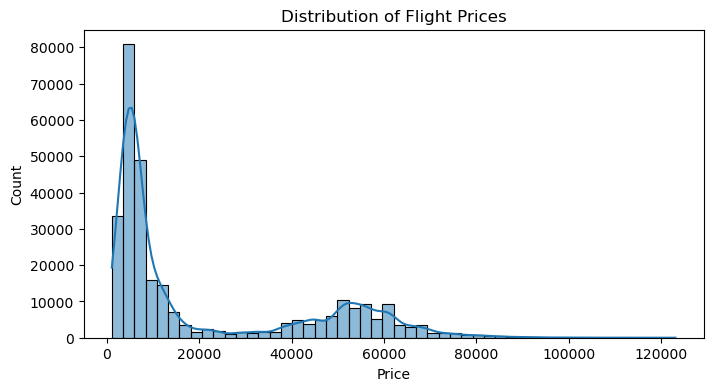

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Flight Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


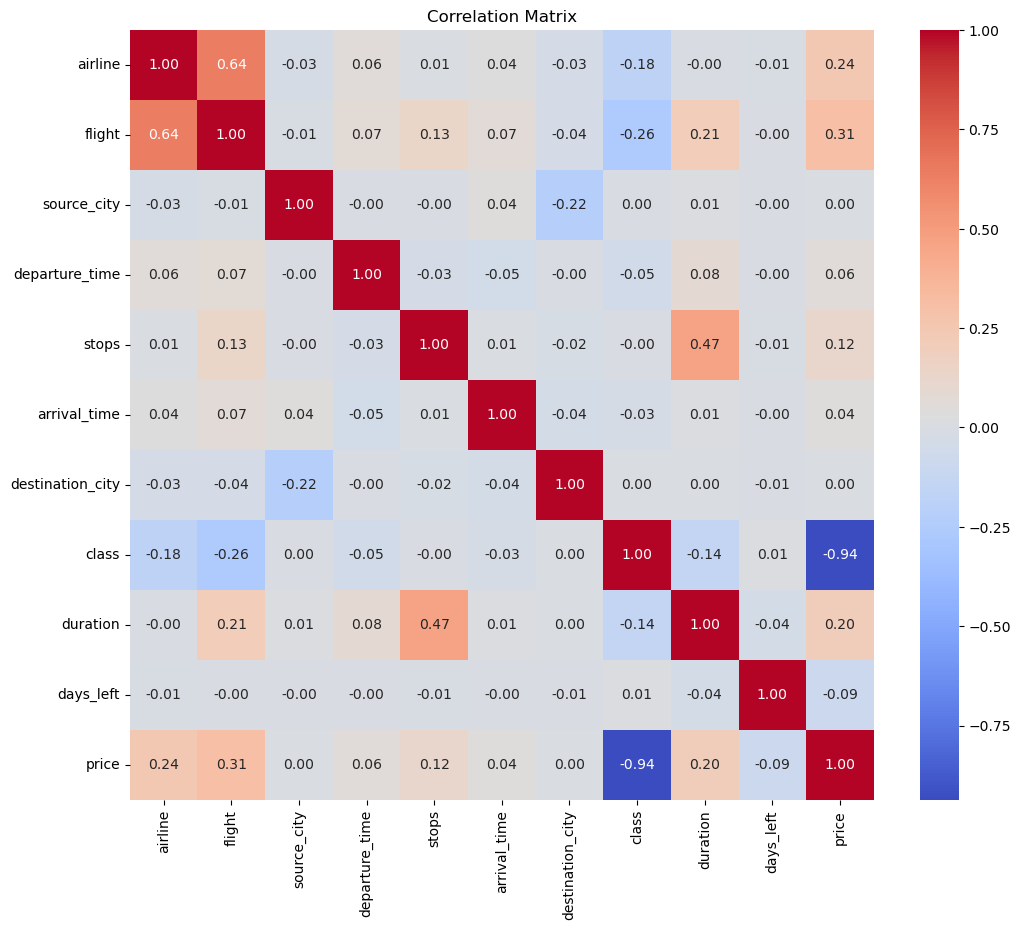

In [12]:
from sklearn.calibration import LabelEncoder


df_encoded = df.copy()
label_cols = ['airline', 'flight', 'source_city', 'departure_time',
              'stops', 'arrival_time', 'destination_city', 'class']

le = LabelEncoder()
for col in label_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


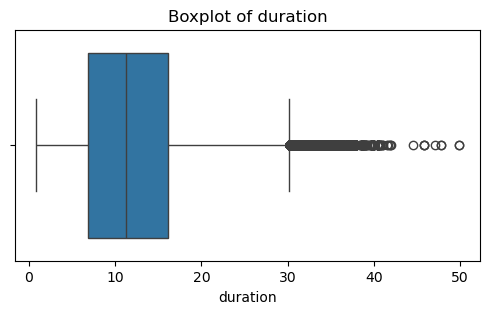

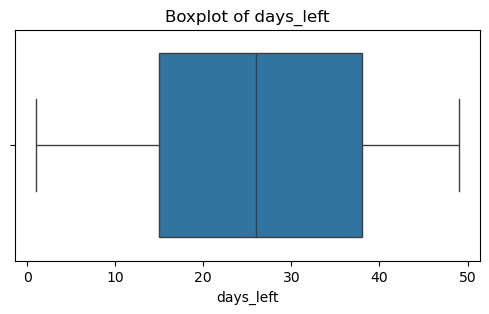

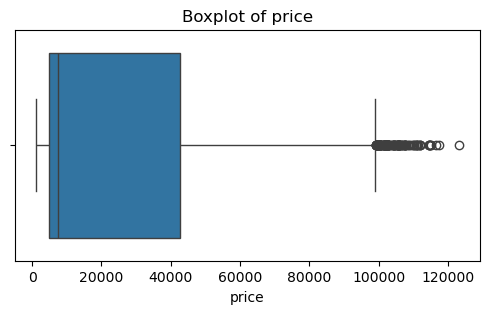

In [13]:
numeric_cols = ['duration', 'days_left', 'price']

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [14]:
X = df.drop('price', axis=1)
y = df['price']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

In [16]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression MAE:", mae_lr)
print("Linear Regression R2:", r2_lr)
print("Linear Regression RMSE:", rmse_lr)

Linear Regression MAE: 4553.28814813038
Linear Regression R2: 0.9113048689284792
Linear Regression RMSE: 6761.713378962222


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import numpy as np

# Step 1: Sample 30% of training data for faster training
X_sampled, _, y_sampled, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

# Step 2: Set up pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # reuse your existing ColumnTransformer
    ('model', RandomForestRegressor(random_state=42))
])

# Step 3: Define param grid to sample from randomly
param_dist = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Step 4: Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Try 5 random combinations
    cv=2,      # 2-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Step 5: Fit the model
random_search.fit(X_sampled, y_sampled)

# Step 6: Predict on the test set
best_rf_model = random_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)


Fitting 2 folds for each of 5 candidates, totalling 10 fits


In [18]:
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 1338.17
RMSE: 3028.93
R² Score: 0.9822


In [19]:
# New flight info
new_data = pd.DataFrame([{
    'airline': 'Vistara',
    'flight': 'UK-123',
    'source_city': 'Delhi',
    'departure_time': 'Morning',
    'stops': 'one',
    'arrival_time': 'Afternoon',
    'destination_city': 'Mumbai',
    'class': 'Economy',
    'duration': 2.25,
    'days_left': 15
}])


In [20]:
predicted_price = random_search.predict(new_data)[0]
print(f"\n🎯 Predicted Flight Price: ₹{predicted_price:,.2f}")



🎯 Predicted Flight Price: ₹2,660.79


In [27]:
import joblib
joblib.dump(random_search, 'model.pkl')

['model.pkl']

In [28]:
import sklearn
print(sklearn.__version__)

1.6.1
